# Post-training Investigation

This notebook uses different methods to assess the quality of generated EEG data. By doing so, we will inform ourselves of possible improvement that can be made to the WGAN's arch to generate more realisitc-looking data.

In [ ]:
# imports
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import sosfilt, butter
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from scipy.signal import welch
from scipy.stats import entropy, skew, kurtosis
from scipy.linalg import sqrtm

import torch
import keras
from sklearn.decomposition import PCA
from src.EEGModalNet.models.WGAN import WGAN_GP
from scipy.stats import wasserstein_distance

## DATA

In [61]:
# Real DATA
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channels = ['O1']
filtering = True
time_dim = 1024
n_subject = 202
exclude_sub_ids=['sub-010257', 'sub-010044', 'sub-010266']

# data
data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')


sub_ids = xarray.subject[:n_subject].to_numpy()
x = xarray.sel(subject=xarray.subject[:n_subject], channel=channels)
if exclude_sub_ids is not None:
    x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
    n_subject = len(x.subject)
x = x.to_numpy()

if filtering:
    sos = butter(4, 1, btype='high', fs=128, output='sos')
    x = sosfilt(sos, x, axis=-1)
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
pos = xarray.ch_positions[None].repeat(x.shape[0], 0)
data = {'x': x, 'sub': sub, 'pos': pos}
signal = x.squeeze().numpy()

In [62]:
# Generated DATA
wgan_gp = WGAN_GP(time_dim=1024, feature_dim=1,
                  latent_dim=64, n_subjects=199,
                  use_sublayer_generator=True,
                  use_sublayer_critic=False,
                  use_channel_merger=False)

i=1840
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
wgan_gp.load_weights(model_path)

x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                              pos).cpu().detach()

signal_gen = x_gen.squeeze().numpy()

## Visual Inspection of X_gen vs. X

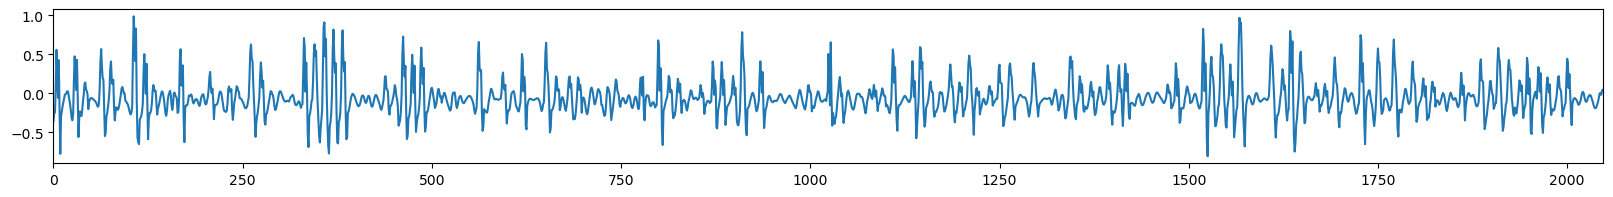

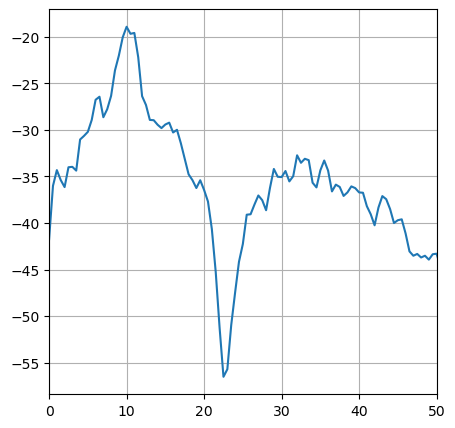

In [22]:
sub = 2
d = 2*1024
s = 10
def plot_segment(x, sub, seg, duration=d, db=False):
    x1 = x[sub*60:(sub+1)*60].flatten()
    plt.figure(figsize=(20, 2))
    segment = x1[seg*duration:(seg+1)*duration]
    plt.plot(segment)
    plt.xlim(0, duration)
    plt.show()
    f, Pxx = welch(segment, fs=128, nperseg=256)
    if db:
        Pxx = 10*np.log10(Pxx)
    plt.figure(figsize=(5, 5))
    plt.plot(f, Pxx)
    plt.xlim(0, 50)
    plt.grid()
    plt.show()

plot_segment(x_gen, sub, s, db=True)

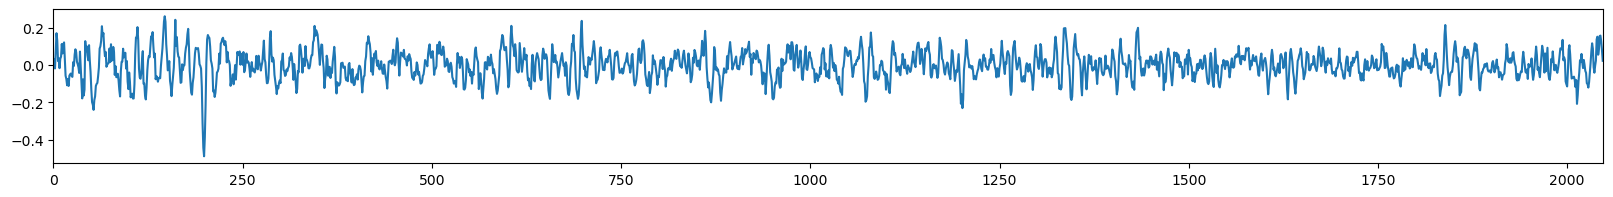

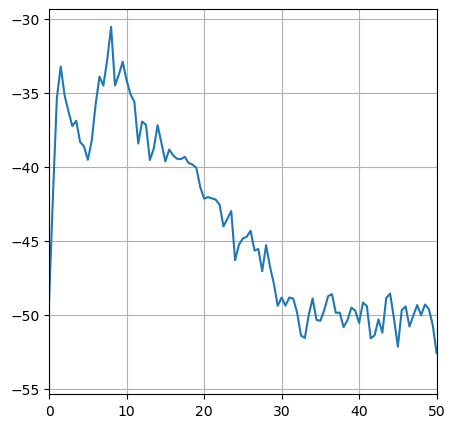

In [17]:
plot_segment(x, sub, s, d, db=True)

## Quantifying the similarity between X_gen & X

In [ ]:
# Wasserstein Distance
wasserstein_distance(x_gen.flatten(), x.flatten())

# Stationarity: consider splitting EEG into smaller windows and computing WD for each window, then averaging the results

0.07223441066468311

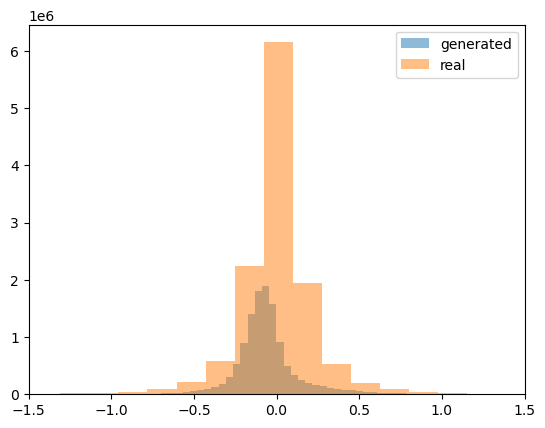

In [ ]:
# visualize amplitude histograms
plt.hist(x_gen.flatten(), bins=100, alpha=0.5, label='generated')
plt.hist(x.flatten(), bins=100, alpha=0.5, label='real')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.show()

## Feature Extraction

In [86]:
## feature extraction
# time domain features
def time_domain_features(x, axis=1):
    mean = np.mean(x, axis=axis)
    std = np.std(x, axis=axis)
    skewness = skew(x, axis=axis)  # equivalent to ((x - mean)**3).mean() / std**3 
    kurtosis_ = kurtosis(x, axis=axis)  # equivalent to ((x - mean)**4).mean() / std**4 when fisher=False
    return np.stack([mean, std, skewness, kurtosis_], axis=1)

# hjorth parameters
def hjorth_parameters(signal, axis=1):
    # Activity
    activity = np.var(signal, axis=axis)

    # Mobility
    first_derivative = np.diff(signal, axis=axis)
    mobility = np.sqrt(np.var(first_derivative, axis=axis) / activity)

    # Complexity
    second_derivative = np.diff(first_derivative, axis=axis)
    complexity = np.sqrt(np.var(second_derivative, axis=axis) / np.var(first_derivative, axis=axis)) / mobility

    return np.stack([activity, mobility, complexity], axis=1)

# RMS Aplitude
def rms_amplitude(signal):
    return np.sqrt(np.mean(signal**2, axis=1))

# Spectral features
def spectral_features(signal):
    f, Pxx = welch(signal, fs=128, nperseg=512)
    total_power = np.sum(Pxx, axis=1)
    delta = np.sum(Pxx[:, (f >= 0.25) & (f < 4)], axis=1) / total_power
    theta = np.sum(Pxx[:, (f >= 4) & (f < 8)], axis=1) / total_power
    alpha = np.sum(Pxx[:, (f >= 8) & (f < 13)], axis=1) / total_power
    beta = np.sum(Pxx[:, (f >= 13) & (f <= 30)], axis=1) / total_power
    gamma = np.sum(Pxx[:, (f > 30) & (f <= 50)], axis=1) / total_power
    pxx_entropy = entropy(Pxx, axis=1)
    return np.stack([delta, theta, alpha, beta, gamma, pxx_entropy], axis=1)

# create a feature matrix
def creat_feature_matrix(signal):
    time_features = time_domain_features(signal)
    hjorth = hjorth_parameters(signal)
    spectral = spectral_features(signal)
    rms = rms_amplitude(signal)
    return np.concatenate([time_features, hjorth, spectral, rms[:, np.newaxis]], axis=1)

In [78]:
# Fréchet Inception Distanc (FID)
def compute_fid(x_features, y_features):
    # Mean and covariance
    mean1, cov1 = x_features.mean(axis=0), np.cov(x_features, rowvar=False)
    mean2, cov2 = y_features.mean(axis=0), np.cov(y_features, rowvar=False)
    # Mean difference
    mean_diff = np.sum((mean1 - mean2)**2)
    
    # Covariance square root
    covmean = sqrtm(cov1 @ cov2)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # FID formula
    fid = mean_diff + np.trace(cov1 + cov2 - 2 * covmean)
    return fid

In [88]:
# compute FID
real_spec_f = spectral_features(signal)
gen_spec_f = spectral_features(signal_gen)
compute_fid(real_spec_f, gen_spec_f)

0.3878989344274333

## Model & Training

In [ ]:
# 2. MODEL and Plot generated data by the model before training
load_model = False
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=False, kerner_initializer='glorot_uniform',
                  interpolation='bilinear')
if load_model:
    wgan_gp.load_weights('logs/models/F1_5.09.2024.model.keras')

x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                          pos).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)
plot_psd(x_gen, fmin=1, ch=0, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=0, fmax=200, n_fft=512, label='real', show=True)
plt.show()

In [ ]:
torch.cuda.empty_cache() # clear GPU memory before training
step_losses_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=10.0)

# early stopping callback
callbacks = [keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500),
             step_losses_history]

In [ ]:
# training
batch_size = 64
history = wgan_gp.fit(data, epochs=20, batch_size=batch_size, callbacks=callbacks, shuffle=True)